## 0. Load Packages

In [3]:
# Standard library imports
import os

# Image processing
import cv2

# Data handling
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.stats import skew
from scipy.ndimage import sobel
from skimage.feature import local_binary_pattern
from numpy.fft import fft2, fftshift

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
                                     Input, SimpleRNN, Conv1D, MaxPooling1D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [7]:
# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
    
# load the labels
clean_labels = np.genfromtxt('data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


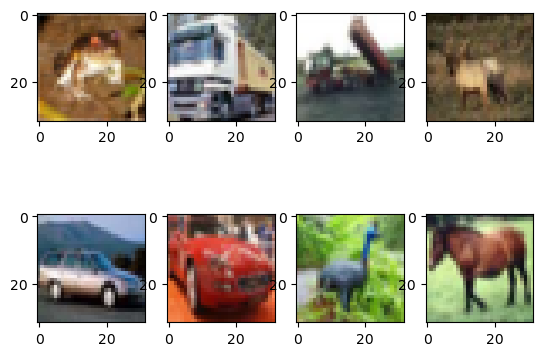

In [9]:
# Add labels
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [10]:
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [11]:
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [12]:
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2 Model I - CNN Neural networks

In [13]:
nn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
nn_model.summary()

/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,826 (1.99 MB)

 Trainable params: 521,866 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Only do a model training based on the first 10000 imgs with cleaned label (8000-2000)
from sklearn.model_selection import train_test_split
import numpy as np

# n_train_img = 10000
n_train_img = 50000
target_vec = np.empty(n_train_img)
i = 0

for i in range(n_train_img):

    # target_vec[i] = clean_labels[i]
    target_vec[i] = noisy_labels[i]


feature = imgs[:n_train_img]



In [10]:
# resized_images = np.array([cv2.resize(img, (32, 32)) for img in feature_mtx])
# target_vec = to_categorical(target_vec, num_classes=10)


In [11]:
target_vec

array([3., 5., 9., ..., 9., 1., 1.])

Epoch 1/3
   6/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.0536 - loss: 3.6457

/Users/jacksonzhao/miniconda3/envs/5243_proj3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - accuracy: 0.1039 - loss: 2.4069 - val_accuracy: 0.0986 - val_loss: 2.3027
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.1190 - loss: 2.2949 - val_accuracy: 0.1028 - val_loss: 2.3041
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.1333 - loss: 2.2836 - val_accuracy: 0.0993 - val_loss: 64.6000


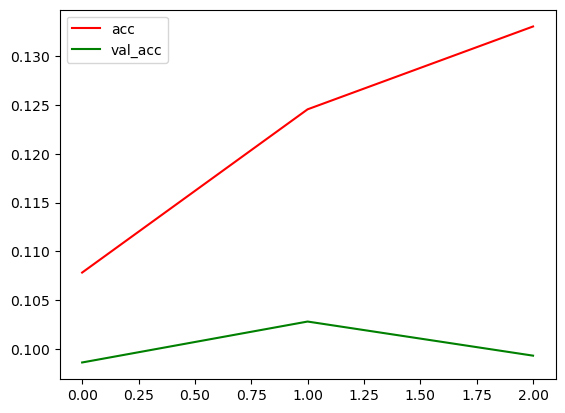

In [12]:
X_train, X_test, y_train, y_test = train_test_split(feature, target_vec, test_size=0.2, random_state=128)
X_train = X_train / 255.0

datagen = ImageDataGenerator(
    rotation_range=20,       # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    zoom_range=0.2,          # randomly zoom images
)

datagen.fit(X_train)

# earlystop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1,
#     restore_best_weights=True
# )
h_callback = nn_model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                                    validation_data=(X_test, y_test),
                                    epochs=3)
                                    # callbacks=[earlystop])

plt.plot(h_callback.history['accuracy'], label='acc', color='red') 
plt.plot(h_callback.history['val_accuracy'], label='val_acc', color='green') 
plt.legend()

In [13]:
# Clean session
tf.keras.backend.clear_session()

## 2.3 Model II

### 2.3.1 Feature Engineering
This step to prove the new features we added has improvement

Accuracy from 0.31 to 0.466 by baseline xgboost with only train/test using 10000 clean labels

In [16]:
# Function for base histogram features
def feature_base(imgs, N_TRAIN_IMG = 10000, NO_BINS = 6, BINS = np.linspace(0, 255, 6)):
    feature_mtx = np.empty((N_TRAIN_IMG, 3 * (len(BINS) - 1)))
    TARGET_VEC = np.empty(N_TRAIN_IMG)
    for i in range(N_TRAIN_IMG):
        TARGET_VEC[i] = clean_labels[i]
        
        # Histogram features for each channel
        feature1 = np.histogram(imgs[i][:, :, 0], bins=BINS)[0]
        feature2 = np.histogram(imgs[i][:, :, 1], bins=BINS)[0]
        feature3 = np.histogram(imgs[i][:, :, 2], bins=BINS)[0]
        
        # Concatenate features
        feature_mtx[i, ] = np.concatenate((feature1, feature2, feature3), axis=None)
    return feature_mtx, TARGET_VEC

# # Function for advanced features including color statistics and edge detection
# def feature_adv(imgs, N_TRAIN_IMG = 10000, NO_BINS = 6, BINS = np.linspace(0, 255, 6)):
#     feature_mtx = np.empty((N_TRAIN_IMG, 26))
#     TARGET_VEC = np.empty(N_TRAIN_IMG)
#     noisy_y = np.empty(N_TRAIN_IMG)

    
#     for i in range(N_TRAIN_IMG):
#         noisy_y[i] = noisy_labels[i]
#         TARGET_VEC[i] = clean_labels[i]  # Assuming clean_labels is defined elsewhere
        
#         # Existing histogram features
#         feature1 = np.histogram(imgs[i][:, :, 0], bins=BINS)[0]
#         feature2 = np.histogram(imgs[i][:, :, 1], bins=BINS)[0]
#         feature3 = np.histogram(imgs[i][:, :, 2], bins=BINS)[0]
        
#         # Color statistics
#         color_features = []
#         for channel in range(3):
#             channel_data = imgs[i][:, :, channel]
#             mean = np.mean(channel_data)
#             std = np.std(channel_data)
#             skewness = skew(channel_data, axis=None)
#             color_features.extend([mean, std, skewness])
        
#         # Edge detection feature
#         sx = sobel(imgs[i][:, :, 0], axis=0, mode='constant')
#         sy = sobel(imgs[i][:, :, 0], axis=1, mode='constant')
#         sobel_magnitude = np.sqrt(sx**2 + sy**2).mean()

        
#         # Concatenate all features
#         feature_mtx[i, ] = np.concatenate((feature1, feature2, feature3, color_features, [sobel_magnitude], [noisy_y[i]]), axis=None)
#     return feature_mtx, TARGET_VEC

def feature_adv(imgs, N_TRAIN_IMG = 10000, NO_BINS = 6, BINS = np.linspace(0, 255, 6), P=8, R=1):
    # Updated to accommodate additional features: LBP and FFT
    feature_mtx = np.empty((N_TRAIN_IMG, 26 + 3 )) 
    TARGET_VEC = np.empty(N_TRAIN_IMG)
    noisy_y = np.empty(N_TRAIN_IMG)

    for i in range(N_TRAIN_IMG):
        noisy_y[i] = noisy_labels[i] 
        TARGET_VEC[i] = clean_labels[i]  
        
        # Existing histogram features
        feature1 = np.histogram(imgs[i][:, :, 0], bins=BINS)[0]
        feature2 = np.histogram(imgs[i][:, :, 1], bins=BINS)[0]
        feature3 = np.histogram(imgs[i][:, :, 2], bins=BINS)[0]
        
        # Color statistics
        color_features = []
        for channel in range(3):
            channel_data = imgs[i][:, :, channel]
            mean = np.mean(channel_data)
            std = np.std(channel_data)
            skewness = skew(channel_data, axis=None)
            color_features.extend([mean, std, skewness])
        
        # Edge detection feature (Sobel)
        sx = sobel(imgs[i][:, :, 0], axis=0, mode='constant')
        sy = sobel(imgs[i][:, :, 0], axis=1, mode='constant')
        sobel_magnitude = np.sqrt(sx**2 + sy**2).mean()

        # Texture features (LBP)
        lbp = local_binary_pattern(imgs[i][:, :, 0], P=P, R=R, method="uniform")
        lbp_mean = np.mean(lbp)
        lbp_var = np.var(lbp)
        
        # Frequency-based features (FFT)
        fft_img = fftshift(fft2(imgs[i][:, :, 0]))
        fft_mean = np.abs(fft_img).mean()

        # Concatenate all features including the new ones
        feature_mtx[i, ] = np.concatenate(
            (feature1, feature2, feature3, color_features, [sobel_magnitude], [lbp_mean], [lbp_var], [fft_mean], [noisy_y[i]]),
            axis=None
        )

    return feature_mtx, TARGET_VEC


def evaluate_feature(feature_mtx, target_vec):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(feature_mtx, target_vec, test_size=0.2, random_state=128)
    
    # Train XGBoost model
    xgb = XGBClassifier(
        learning_rate=0.1,
        n_estimators=500,
        objective='binary:logistic',  # Adjust based on your task (binary or multi-class)
        use_label_encoder=False,  # To avoid a deprecation warning
        eval_metric='logloss'  # To avoid a deprecation warning
    )
    xgb_m = xgb.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = xgb_m.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Get feature importances
    feature_importances = xgb_m.feature_importances_
    
    # Plot feature importances
    plt.figure(figsize=(10, 8))
    indices = np.argsort(feature_importances)[::-1]
    plt.title("Feature Importances")
    plt.bar(range(X_train.shape[1]), feature_importances[indices], color="r", align="center")
    plt.ylabel('Importance Score')
    plt.xlabel('Feature Index')
    plt.show()

    return accuracy

/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Evaluating Base Features...


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:14:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.3055


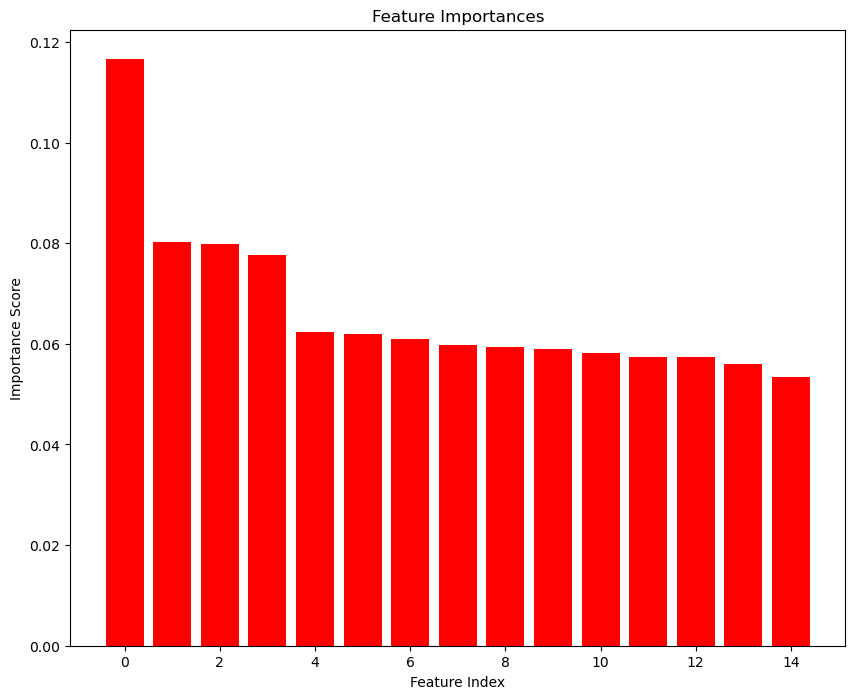

Evaluating Advanced Features...


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:14:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.4825


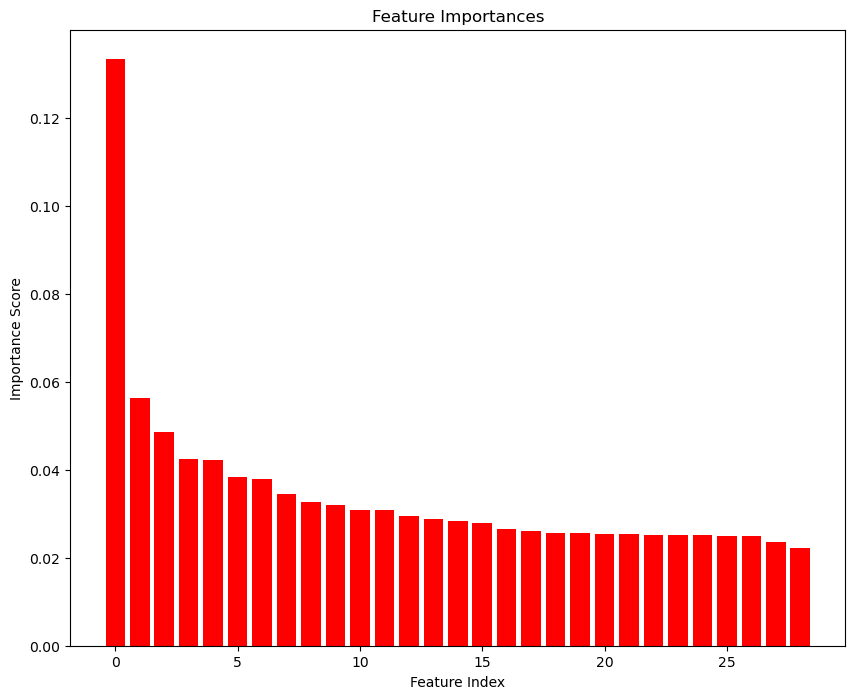

In [17]:
# Constants
NO_BINS = 6
N_TRAIN_IMG = 10000
BINS = np.linspace(0, 255, NO_BINS)


target_vec = np.empty(N_TRAIN_IMG)  # Initialize target vector

# Feature extraction
feature_mtx_base, target_vec_base = feature_base(imgs)  # For base features
feature_mtx_adv, target_vec_adv = feature_adv(imgs)  # For advanced features


# Evaluate features
print("Evaluating Base Features...")
accuracy_base = evaluate_feature(feature_mtx_base, target_vec_base)
print("Evaluating Advanced Features...")
accuracy_adv = evaluate_feature(feature_mtx_adv, target_vec_adv)

### 2.3.2 Generate 50000 labels better than noisy labels using 10000 labels (noisy and clean)

#### 2.3.2.1 Generate Features
Also add noisy label as one of the predictors

In [18]:
n_train_img = 10000
noisy_y = np.empty(n_train_img)
clean_y = np.empty(n_train_img)
feature_mtx = np.empty((n_train_img,26))

# Generate noisy and clean labels
for i in range(n_train_img):
    noisy_y[i] = noisy_labels[i]
    clean_y[i] = clean_labels[i]

#### 2.3.2.2 Model Selection

XGBoost is the best

In [19]:
# Assuming 'feature_mtx', 'clean_y' are already defined
X_train, X_val, y_train, y_val = train_test_split(feature_mtx_adv, clean_y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model dictionary for traditional ML models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
}

# Train and evaluate each traditional ML model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {accuracy}")

# Neural Network
model_nn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(clean_y)), activation='softmax')
])

model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_nn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=2)
loss, accuracy_nn = model_nn.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Neural Network Accuracy: {accuracy_nn}")

# Simplified CNN Example
model_cnn = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(clean_y)), activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=2)
accuracy_cnn = model_cnn.evaluate(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1), y_val, verbose=0)[1]
print(f"CNN Accuracy: {accuracy_cnn}")

# Simplified RNN Example
model_rnn = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),
    SimpleRNN(64),
    Dense(len(np.unique(clean_y)), activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_rnn.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=2)
accuracy_rnn = model_rnn.evaluate(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1), y_val, verbose=0)[1]
print(f"RNN Accuracy: {accuracy_rnn}")

# Generate and print classification report for each model
predictions = []
# Collect predictions from traditional ML models
for name, model in models.items():
    y_pred = model.predict(X_val_scaled)
    predictions.append((name, y_pred))

# Neural Network prediction
y_pred_nn = model_nn.predict(X_val_scaled)
y_pred_nn = np.argmax(y_pred_nn, axis=1)  # Convert probabilities to class labels
predictions.append(("Neural Network", y_pred_nn))

# CNN prediction
y_pred_cnn = model_cnn.predict(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1))
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
predictions.append(("CNN", y_pred_cnn))

# RNN prediction
y_pred_rnn = model_rnn.predict(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1))
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
predictions.append(("RNN", y_pred_rnn))

# Print classification reports
for name, y_pred in predictions:
    print(f"Classification Report for {name}:")
    print(classification_report(y_val, y_pred))
    print("\n" + "="*60 + "\n")

Random Forest Accuracy: 0.4325


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:14:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.4695
Logistic Regression Accuracy: 0.407
KNN Accuracy: 0.3235
SVM Accuracy: 0.4335
Epoch 1/10
250/250 - 0s - 2ms/step - accuracy: 0.3114 - loss: 1.9435
Epoch 2/10
250/250 - 0s - 502us/step - accuracy: 0.3871 - loss: 1.7366
Epoch 3/10
250/250 - 0s - 431us/step - accuracy: 0.4014 - loss: 1.6779
Epoch 4/10
250/250 - 0s - 427us/step - accuracy: 0.4239 - loss: 1.6369
Epoch 5/10
250/250 - 0s - 435us/step - accuracy: 0.4302 - loss: 1.6082
Epoch 6/10
250/250 - 0s - 432us/step - accuracy: 0.4426 - loss: 1.5830
Epoch 7/10
250/250 - 0s - 436us/step - accuracy: 0.4436 - loss: 1.5622
Epoch 8/10
250/250 - 0s - 435us/step - accuracy: 0.4524 - loss: 1.5426
Epoch 9/10
250/250 - 0s - 435us/step - accuracy: 0.4566 - loss: 1.5309
Epoch 10/10
250/250 - 0s - 432us/step - accuracy: 0.4694 - loss: 1.5075
Neural Network Accuracy: 0.43549999594688416
Epoch 1/10
250/250 - 1s - 2ms/step - accuracy: 0.2776 - loss: 1.9760
Epoch 2/10
250/250 - 0s - 1ms/step - accuracy: 0.3460 - loss: 1.8166
Epoch

#### 2.3.2.3 Tune Parameter
80% clean label to train model (10 C-V), using 20% to validate, calculating accuracy.

Then using the best model to generate labels for the rest 40000 images 

##### 2.3.2.3.1 Random Search CV

In [20]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(feature_mtx_adv, clean_y, test_size=0.2, random_state=42)

# Define the parameter space for Randomized Search
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.3, 0.5, 0.7],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'min_child_weight': [1, 5, 10]
}

# Initialize the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Setup RandomizedSearchCV with verbose output
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=3, scoring='accuracy', n_jobs=-1, cv=10, random_state=42, verbose=3)

# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters found: ", random_search.best_params_)
    
# Use the best estimator to make predictions on the validation set and the entire dataset
y_pred_val = random_search.best_estimator_.predict(X_val)
y_pred_full = random_search.best_estimator_.predict(feature_mtx_adv)

# Calculate and print accuracies
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_full_clean = accuracy_score(clean_y, y_pred_full)
accuracy_full_noisy = accuracy_score(noisy_y, y_pred_full)
print(f"Validation Accuracy: {accuracy_val}")
print(f"Full Dataset Accuracy (vs Clean Labels): {accuracy_full_clean}")
print(f"Full Dataset Accuracy (vs Noisy Labels): {accuracy_full_noisy}")

# Calculate and print precision and recall for the validation set
precision_val = precision_score(y_val, y_pred_val, average='macro')
recall_val = recall_score(y_val, y_pred_val, average='macro')
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

# Feature importance from the best model
feature_importances = random_search.best_estimator_.feature_importances_
print("Feature Importances: ", feature_importances)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:04] WARNING: /Users/runner/work/xgb

[CV 3/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.484 total time=   3.7s
[CV 6/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.502 total time=   3.7s
[CV 8/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.517 total time=   3.7s
[CV 5/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.468 total time=   3.8s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.480 total time=   3.8s
[CV 4/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.475 total time=   3.8s
[CV 2/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_chil

/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgb

[CV 10/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.477 total time=   4.0s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 9/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.491 total time=   4.7s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.468 total time=   8.2s
[CV 5/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.440 total time=   8.3s
[CV 3/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.446 total time=   8.4s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.455 total time=   8.5s
[CV 1/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.434 total time=   8.7s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 6/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.459 total time=   8.6s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.465 total time=   2.3s
[CV 2/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.456 total time=   2.3s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.474 total time=   2.4s
[CV 4/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.472 total time=   2.3s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 7/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.460 total time=   8.4s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.465 total time=   2.6s
[CV 6/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.504 total time=   2.6s
[CV 8/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.476 total time=   2.5s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 7/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.476 total time=   2.6s
[CV 9/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.469 total time=   2.3s
[CV 8/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.459 total time=  10.3s
[CV 10/10] END colsample_bytree=0.75, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.3;, score=0.470 total time=   2.0s
[CV 9/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.466 total time=   7.8s
[CV 10/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.466 total time=   8.0s


/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:16:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters found:  {'subsample': 0.3, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Validation Accuracy: 0.4855
Full Dataset Accuracy (vs Clean Labels): 0.685
Full Dataset Accuracy (vs Noisy Labels): 0.5195
Validation Precision: 0.48287708653974837
Validation Recall: 0.48433385696492415
Feature Importances:  [0.03145526 0.0295003  0.02872325 0.02882197 0.02903622 0.03257385
 0.02942315 0.02862318 0.0288812  0.02967811 0.03020539 0.03695293
 0.02930328 0.03476233 0.04072488 0.03072959 0.03231994 0.03010118
 0.03062777 0.03230799 0.03133248 0.04282452 0.03549644 0.03697075
 0.03668107 0.03088158 0.03794918 0.03391997 0.08919225]


##### 2.3.2.3.2 Bayesian Optimization

In [22]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Assuming feature_mtx_adv, clean_y, and noisy_y are already defined
X_train, X_val, y_train, y_val = train_test_split(feature_mtx_adv, clean_y, test_size=0.2, random_state=42)

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_categorical('n_estimators', [1500, 2000, 3000, 4000, 5000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), 
        'subsample': trial.suggest_float('subsample', 0.3, 0.7),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 10]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0), 
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 5, 7, 10]),
    }
    
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Best Parameters found: ", best_params)

# Use the best parameters to train the final model
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Make predictions
y_pred_val = model.predict(X_val)
y_pred_full = model.predict(feature_mtx_adv)

# Calculate metrics
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_full_clean = accuracy_score(clean_y, y_pred_full)
accuracy_full_noisy = accuracy_score(noisy_y, y_pred_full)

precision_val = precision_score(y_val, y_pred_val, average='macro')
recall_val = recall_score(y_val, y_pred_val, average='macro')

print(f"Validation Accuracy: {accuracy_val}")
print(f"Full Dataset Accuracy (vs Clean Labels): {accuracy_full_clean}")
print(f"Full Dataset Accuracy (vs Noisy Labels): {accuracy_full_noisy}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

# Feature importance from the best model
feature_importances = model.feature_importances_
print("Feature Importances: ", feature_importances)

/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-03 21:17:18,117] A new study created in memory with name: no-name-d198a156-83f4-42fc-b23f-774cc7ab706c
[I 2024-09-03 21:18:04,006] Trial 0 finished with value: 0.467 and parameters: {'n_estimators': 5000, 'learning_rate': 0.12096339153798748, 'subsample': 0.6199886827392571, 'max_depth': 5, 'colsample_bytree': 0.7200353776535048, 'min_child_weight': 10}. Best is trial 0 with value: 0.467.
[I 2024-09-03 21:18:18,776] Trial 1 finished with value: 0.4615 and parameters: {'n_estimators': 1500, 'learning_rate': 0.23377586305057563, 'subsample': 0.4902099334362733, 'max_depth': 5, 'colsample_bytree': 0.6523464993473718, 'min_child_weight': 7}. Best is trial 0 with value: 0.467.
[I 2024-09-03 21:18

Best Parameters found:  {'n_estimators': 3000, 'learning_rate': 0.09934998872169747, 'subsample': 0.6982033681702247, 'max_depth': 5, 'colsample_bytree': 0.4660852937372884, 'min_child_weight': 5}
Validation Accuracy: 0.4775
Full Dataset Accuracy (vs Clean Labels): 0.8955
Full Dataset Accuracy (vs Noisy Labels): 0.4195
Validation Precision: 0.47468558129022914
Validation Recall: 0.4759672201245565
Feature Importances:  [0.02934787 0.02720201 0.02629395 0.02719319 0.02702975 0.03130747
 0.02728813 0.02484256 0.02583163 0.02571991 0.0293117  0.03635169
 0.02773303 0.03378624 0.04167846 0.02965359 0.03213489 0.02904052
 0.03004278 0.03085091 0.02903456 0.04465204 0.03637152 0.03653537
 0.03779892 0.03036079 0.0390939  0.03249532 0.12101727]


#### 2.3.2.4 Save Best Model

In [23]:
import pickle
model = XGBClassifier(**best_params)

# Using all 10000 clean labels and images to retrain the model with the best parameters
model.fit(feature_mtx_adv, clean_y)

# Save this best model to a pickle file
with open('../best_model_xgboost.pkl', 'wb') as file:  
    pickle.dump(model, file)

print("The best model was saved to '../best_model.pkl'")

The best model was saved to '../best_model.pkl'


In [25]:
# Print hyperparameters of the model
print("Model Hyperparameters:")
print(model.get_params())
# Print feature importances
print("Feature Importances:")
print(model.feature_importances_)

Model Hyperparameters:
{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.4660852937372884, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.09934998872169747, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 3000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6982033681702247, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Feature Importances:
[0.02960759 0.027725

#### 2.3.2.5 Load Best Model

In [26]:
import pickle

model_path = '../best_model_xgboost.pkl'

# Load the model from the pickle file
with open(model_path, 'rb') as file:
    model = pickle.load(file)

print("The model has been successfully loaded.")

The model has been successfully loaded.


In [27]:
# Print hyperparameters of the model
print("Model Hyperparameters:")
print(model.get_params())
# Print feature importances
print("Feature Importances:")
print(model.feature_importances_)
# Dump model
print("Model Dump:")
dump_list = model.get_booster().get_dump()
for tree in dump_list[:2]:  # Just print the first two trees
    print(tree)

Model Hyperparameters:
{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.4660852937372884, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.09934998872169747, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 3000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6982033681702247, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Feature Importances:
[0.02960759 0.027725

# Run at Presentation Date

In [30]:
# 50000 images features
clean_labels = np.genfromtxt('data/test_data/test_labels.csv',
                             delimiter=',', dtype="int8") # 50000 actual labels

n_img = 10000
for i in range(n_img):
    img_fn = f'data/test_data/test_images/test{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

feature_mtx_adv, target_vec_adv = feature_adv(imgs, N_TRAIN_IMG = 10000)

y_pred = model.predict(feature_mtx_adv) # Generate 50000 prediction labels

/Users/jacksonzhao/miniconda3/envs/image-classification/lib/python3.9/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [31]:
print(classification_report(clean_labels, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.46      0.44      1000
           1       0.32      0.32      0.32      1000
           2       0.30      0.30      0.30      1000
           3       0.22      0.20      0.21      1000
           4       0.33      0.32      0.32      1000
           5       0.26      0.23      0.24      1000
           6       0.43      0.47      0.45      1000
           7       0.28      0.26      0.27      1000
           8       0.41      0.47      0.44      1000
           9       0.34      0.34      0.34      1000

    accuracy                           0.34     10000
   macro avg       0.33      0.34      0.33     10000
weighted avg       0.33      0.34      0.33     10000



In [35]:
import pandas as pd

# Convert the array to a pandas DataFrame
predictions_df = pd.DataFrame(y_pred)

# Save the DataFrame to a CSV file
predictions_df.to_csv('data/predict_labels_xgboost.csv', index=False, header=False, )

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [36]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [38]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('data/test_data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'data/test_data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.25      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.